## Module 5: Analyse, diagnose and improve a model​

In the excercise of this week you will be working with financial data in order to (hopefully) find a portfolio of equities which outperform SP500. The data that you are gonna work with has two main sources: 
* Financial data from the companies extracted from the quarterly company reports (mostly extracted from [macrotrends](https://www.macrotrends.net/) so you can use this website to understand better the data and get insights on the features, for example [this](https://www.macrotrends.net/stocks/charts/AAPL/apple/revenue) is the one corresponding to APPLE)
* Stock prices, mostly extracted from [morningstar](https://indexes.morningstar.com/page/morningstar-indexes-empowering-investor-success?utm_source=google&utm_medium=cpc&utm_campaign=MORNI%3AG%3ASearch%3ABrand%3ACore%3AUK%20MORNI%3ABrand%3ACore%3ABroad&utm_content=engine%3Agoogle%7Ccampaignid%3A18471962329%7Cadid%3A625249340069&utm_term=morningstar%20index&gclid=CjwKCAjws9ipBhB1EiwAccEi1Fu6i20XHVcxFxuSEtJGF0If-kq5-uKnZ3rov3eRkXXFfI5j8QBtBBoCayEQAvD_BwE), which basically tell us how the stock price is evolving so we can use it both as past features and the target to predict).

Before going to the problem that we want to solve, let's comment some of the columns of the dataset:


* `Ticker`: a [short name](https://en.wikipedia.org/wiki/Ticker_symbol) to identify the equity (that you can use to search in macrotrends)
* `date`: the date of the company report (normally we are gonna have 1 every quarter). This is for informative purposes but you can ignore it when modeling.
* `execution date`: the date when we would had executed the algorithm for that equity. We want to execute the algorithm once per quarter to create the portfolio, but the release `date`s of all the different company reports don't always match for the quarter, so we just take a common `execution_date` for all of them.
* `stock_change_div_365`: what is the % change of the stock price (with dividens) in the FOLLOWING year after `execution date`. 
* `sp500_change_365`: what is the % change of the SP500 in the FOLLOWING year after `execution date`.
* `close_0`: what is the price at the moment of `execution date`
* `stock_change__minus_120` what is the % change of the stock price in the last 120 days
* `stock_change__minus_730`: what is the % change of the stock price in the last 730 days

The rest of the features can be divided beteween financial features (the ones coming from the reports) and technical features (coming from the stock price). We leave the technical features here as a reference: 

In [3]:
technical_features = [
    "close_0",
    "close_sp500_0",
    "close_365",
    "close_sp500_365",
    "close__minus_120",
    "close_sp500__minus_120",
    "close__minus_365",
    "close_sp500__minus_365",
    "close__minus_730",
    "close_sp500__minus_730",
    "stock_change_365",
    "stock_change_div_365",
    "sp500_change_365",
    "stock_change__minus_120",
    "sp500_change__minus_120",
    "stock_change__minus_365",
    "sp500_change__minus_365",
    "stock_change__minus_730",
    "sp500_change__minus_730",
    "std__minus_365",
    "std__minus_730",
    "std__minus_120",
]

The problem that we want to solve is basically find a portfolio of `top_n` tickers (initially set to 10) to invest every `execution date` (basically once per quarter) and the goal is to have a better return than `SP500` in the following year. The initial way to model this is to have a binary target which is 1 when `stock_change_div_365` - `sp500_change_365` (the difference between the return of the equity and the SP500 in the following year) is positive or 0 otherwise. So we try to predict the probability of an equity of improving SP500 in the following year, we take the `top_n` equities and compute their final return.

In [4]:
import pandas as pd
import re
import numpy as np
import lightgbm as lgb
from plotnine import (
    ggplot,
    geom_histogram,
    geom_boxplot,
    aes,
    geom_col,
    coord_flip,
    geom_bar,
    scale_x_discrete,
    geom_point,
    theme,
    element_text,
    coord_cartesian,
)

In [5]:
# number of trees in lightgbm
n_trees = 40
minimum_number_of_tickers = 1500
# Number of the quarters in the past to train
n_train_quarters = 36
# number of tickers to make the portfolio
top_n = 10

In [6]:
filename = "../../data/module5/financials_against_return.feather"

In [7]:
data_set = pd.read_feather(filename)

Remove these quarters which have les than `minimum_number_of_tickers` tickers:

In [8]:
df_quarter_lengths = (
    data_set.groupby(["execution_date"])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
)
data_set = pd.merge(data_set, df_quarter_lengths, on=["execution_date"])
data_set = data_set[data_set["count"] >= minimum_number_of_tickers]

In [9]:
data_set.shape

(170483, 145)

Create the target:

In [10]:
data_set["diff_ch_sp500"] = (
    data_set["stock_change_div_365"] - data_set["sp500_change_365"]
)

data_set.loc[data_set["diff_ch_sp500"] > 0, "target"] = 1
data_set.loc[data_set["diff_ch_sp500"] < 0, "target"] = 0

data_set["target"].value_counts()

target
0.0    82437
1.0    73829
Name: count, dtype: int64

This function computes the main metric that we want to optimize: given a prediction where we have probabilities for each equity, we sort the equities in descending order of probability, we pick the `top_n` ones, and we we weight the returned `diff_ch_sp500` by the probability:

In [11]:
def get_weighted_performance_of_stocks(df, metric):
    df["norm_prob"] = 1 / len(df)
    return np.sum(df["norm_prob"] * df[metric])


def get_top_tickers_per_prob(preds):
    if len(preds) == len(train_set):
        data_set = train_set.copy()
    elif len(preds) == len(test_set):
        data_set = test_set.copy()
    else:
        assert "Not matching train/test"
    data_set["prob"] = preds
    data_set = data_set.sort_values(["prob"], ascending=False)
    data_set = data_set.head(top_n)
    return data_set


# main metric to evaluate: average diff_ch_sp500 of the top_n stocks
def top_wt_performance(preds, train_data):
    top_dataset = get_top_tickers_per_prob(preds)
    return (
        "weighted-return",
        get_weighted_performance_of_stocks(top_dataset, "diff_ch_sp500"),
        True,
    )

We have created for you a function to make the `train` and `test` split based on a `execution_date`:

In [12]:
def split_train_test_by_period(
    data_set, test_execution_date, include_nulls_in_test=False
):
    # we train with everything happening at least one year before the test execution date
    train_set = data_set.loc[
        data_set["execution_date"]
        <= pd.to_datetime(test_execution_date) - pd.Timedelta(350, unit="day")
    ]
    # remove those rows where the target is null
    train_set = train_set[~pd.isna(train_set["diff_ch_sp500"])]
    execution_dates = train_set.sort_values("execution_date")["execution_date"].unique()
    # Pick only the last n_train_quarters
    if n_train_quarters != None:
        train_set = train_set[
            train_set["execution_date"].isin(execution_dates[-n_train_quarters:])
        ]

    # the test set are the rows happening in the execution date with the concrete frequency
    test_set = data_set.loc[(data_set["execution_date"] == test_execution_date)]
    if not include_nulls_in_test:
        test_set = test_set[~pd.isna(test_set["diff_ch_sp500"])]
    test_set = test_set.sort_values("date", ascending=False).drop_duplicates(
        "Ticker", keep="first"
    )

    return train_set, test_set

Ensure that we don't include features which are irrelevant or related to the target:

In [13]:
def get_columns_to_remove():
    columns_to_remove = [
        "date",
        "improve_sp500",
        "Ticker",
        "freq",
        "set",
        "close_sp500_365",
        "close_365",
        "stock_change_365",
        "sp500_change_365",
        "stock_change_div_365",
        "stock_change_730",
        "sp500_change_365",
        "stock_change_div_730",
        "diff_ch_sp500",
        "diff_ch_avg_500",
        "execution_date",
        "target",
        "index",
        "quarter",
        "std_730",
        "count",
    ]

    return columns_to_remove

This is the main modeling function, it receives a train test and a test set and trains a `lightgbm` in classification mode. We don't recommend to change the main algorithm for this excercise but we suggest to play with its hyperparameters:

In [14]:
import warnings

warnings.filterwarnings("ignore")


def train_model(train_set, test_set, n_estimators=300):
    columns_to_remove = get_columns_to_remove()

    X_train = train_set.drop(columns=columns_to_remove, errors="ignore")
    X_test = test_set.drop(columns=columns_to_remove, errors="ignore")

    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

    eval_result = {}

    objective = "binary"
    metric = "binary_logloss"
    params = {
        "random_state": 1,
        "verbosity": -1,
        "n_jobs": 10,
        "n_estimators": n_estimators,
        "objective": objective,
        "metric": metric,
    }

    model = lgb.train(
        params=params,
        train_set=lgb_train,
        valid_sets=[lgb_test, lgb_train],
        feval=[top_wt_performance],
        callbacks=[lgb.record_evaluation(eval_result=eval_result)],
    )
    return model, eval_result, X_train, X_test

This is the function which receives an `execution_date` and splits the dataset between train and test, trains the models and evaluates the model in test. It returns a dictionary with the different evaluation metrics in train and test:

In [15]:
def run_model_for_execution_date(
    execution_date,
    all_results,
    all_predicted_tickers_list,
    all_models,
    n_estimators,
    include_nulls_in_test=False,
):
    global train_set
    global test_set
    # split the dataset between train and test
    train_set, test_set = split_train_test_by_period(
        data_set, execution_date, include_nulls_in_test=include_nulls_in_test
    )
    train_size, _ = train_set.shape
    test_size, _ = test_set.shape
    model = None
    X_train = None
    X_test = None

    # if both train and test are not empty
    if train_size > 0 and test_size > 0:
        model, evals_result, X_train, X_test = train_model(
            train_set, test_set, n_estimators=n_estimators
        )

        test_set["prob"] = model.predict(X_test)
        predicted_tickers = test_set.sort_values("prob", ascending=False)
        predicted_tickers["execution_date"] = execution_date
        all_results[(execution_date)] = evals_result
        all_models[(execution_date)] = model
        all_predicted_tickers_list.append(predicted_tickers)
    return all_results, all_predicted_tickers_list, all_models, model, X_train, X_test


execution_dates = np.sort(data_set["execution_date"].unique())

This is the main training loop: it goes through each different `execution_date` and calls `run_model_for_execution_date`. All the results are stored in `all_results` and the predictions in `all_predicted_tickers_list`.

In [16]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

for execution_date in execution_dates:
    print(execution_date)
    all_results, all_predicted_tickers_list, all_models, model, X_train, X_test = (
        run_model_for_execution_date(
            execution_date,
            all_results,
            all_predicted_tickers_list,
            all_models,
            n_trees,
            False,
        )
    )
all_predicted_tickers = pd.concat(all_predicted_tickers_list)

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

In [17]:
def parse_results_into_df(set_):
    df = pd.DataFrame()
    for date in all_results:
        df_tmp = pd.DataFrame(all_results[(date)][set_])
        df_tmp["n_trees"] = list(range(len(df_tmp)))
        df_tmp["execution_date"] = date
        df = pd.concat([df, df_tmp])

    df["execution_date"] = df["execution_date"].astype(str)

    return df

In [18]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

In [19]:
test_results_final_tree = test_results.sort_values(
    ["execution_date", "n_trees"]
).drop_duplicates("execution_date", keep="last")
train_results_final_tree = train_results.sort_values(
    ["execution_date", "n_trees"]
).drop_duplicates("execution_date", keep="last")


And this are the results:

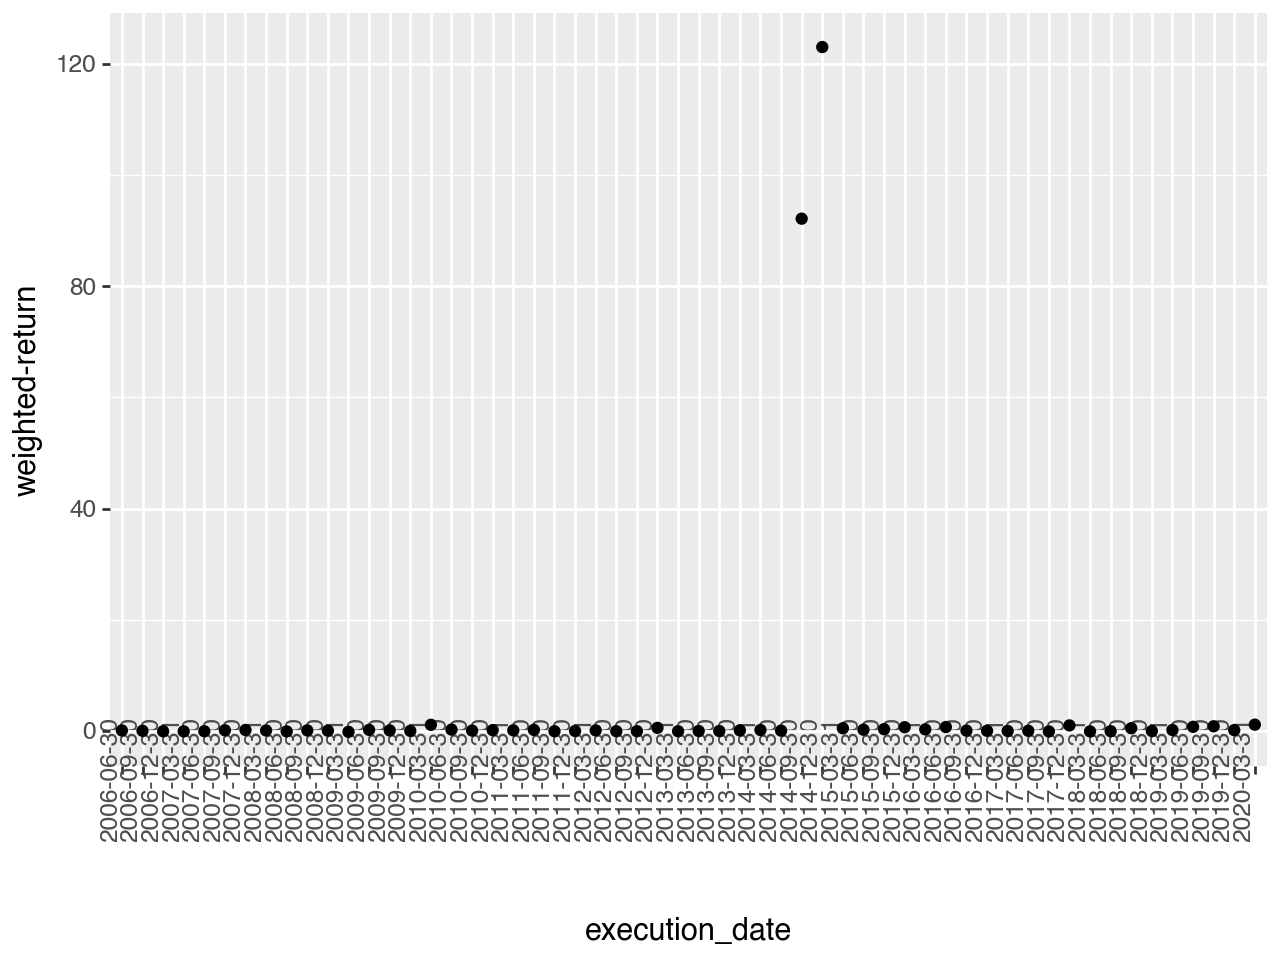

In [20]:
(
    ggplot(test_results_final_tree)
    + geom_point(aes(x="execution_date", y="weighted-return"))
    + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1))
)


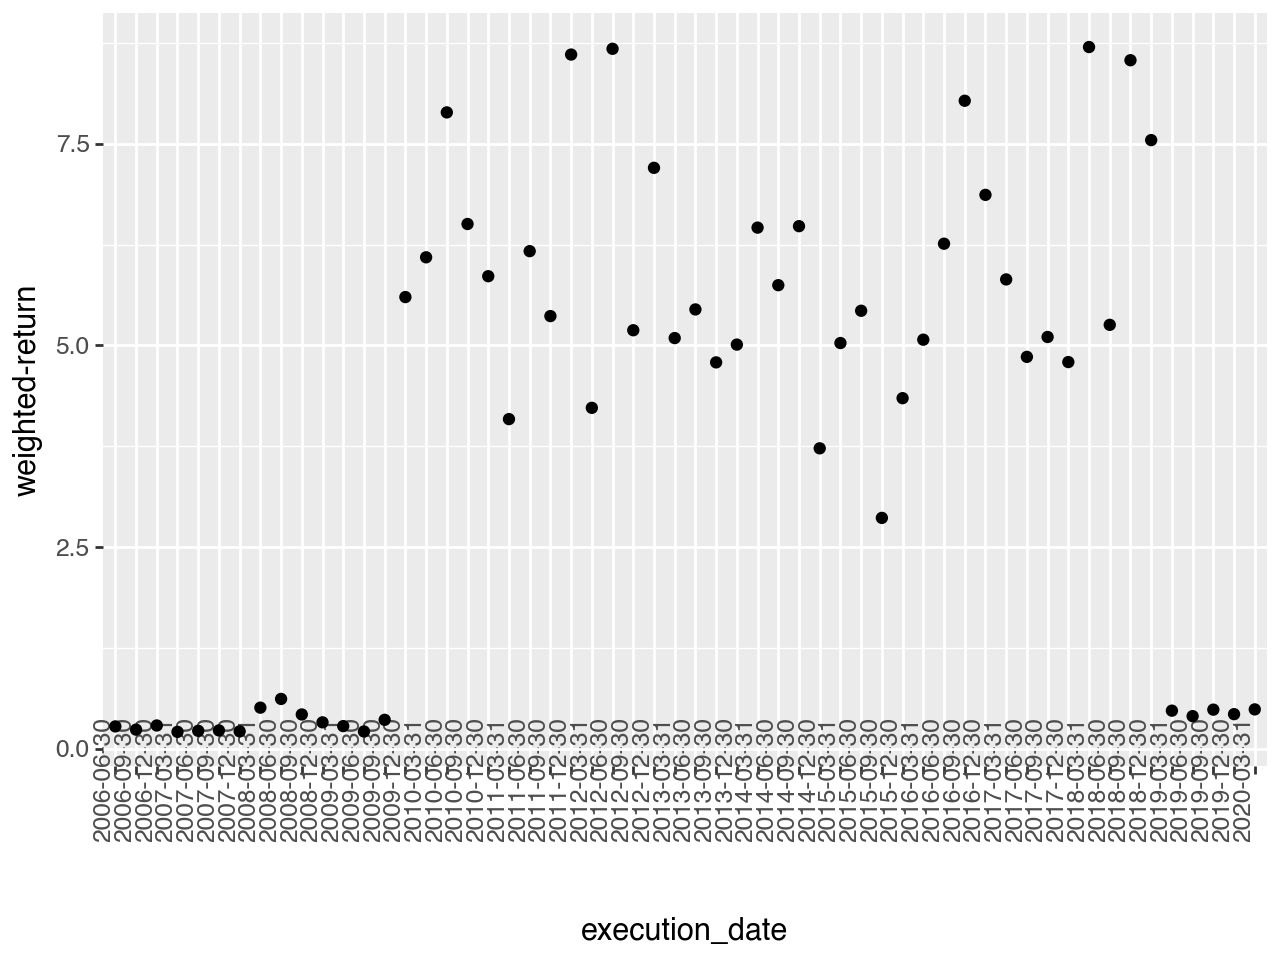

In [21]:
(
    ggplot(train_results_final_tree)
    + geom_point(aes(x="execution_date", y="weighted-return"))
    + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1))
)


We have trained the first models for all the periods for you, but there are a lot of things which may be wrong or can be improved. Some ideas where you can start:
* Try to see if there is any kind of data leakage or suspicious features
* If the training part is very slow, try to see how you can modify it to execute faster tests
* Try to understand if the algorithm is learning correctly
* We are using a very high level metric to evaluate the algorithm so you maybe need to use some more low level ones
* Try to see if there is overfitting
* Try to see if there is a lot of noise between different trainings
* To simplify, why if you only keep the first tickers in terms of Market Cap?
* Change the number of quarters to train in the past

This function can be useful to compute the feature importance:

In [22]:
def draw_feature_importance(model, top=15):
    fi = model.feature_importance()
    fn = model.feature_name()
    feature_importance = pd.DataFrame(
        [{"feature": fn[i], "imp": fi[i]} for i in range(len(fi))]
    )
    feature_importance = feature_importance.sort_values("imp", ascending=False).head(
        top
    )
    feature_importance = feature_importance.sort_values("imp", ascending=True)
    plot = (
        ggplot(feature_importance, aes(x="feature", y="imp"))
        + geom_col(fill="lightblue")
        + coord_flip()
        + scale_x_discrete(limits=feature_importance["feature"])
    )
    return plot


In [23]:
from scipy.stats import lognorm
import matplotlib.pyplot as plt

# Checks

First of all, we have to notice that a classification model has been used instead of a regression model to simplify the output to a binary variable. With regression, the output has a much higher variance and it might be harder to obtain precise results.

## Baseline model
As always, we are going to build a baseline model in order to compare the results of the built model and see if it is worth it. The baseline model is going to be a simple model: the return of the last year is going to be the return of the next year. This is a very simple model, but it is a good starting point.

In [24]:
def merge_against_benchmark(metrics_df, all_predicted_tickers, top_n_market_cap=500):
    # Sort by execution_date and Market_cap
    all_predicted_tickers = all_predicted_tickers.sort_values(
        ["execution_date", "Market_cap"], ascending=False
    )
    all_predicted_tickers["rank"] = all_predicted_tickers.groupby(
        "execution_date"
    ).cumcount()
    all_predicted_tickers_top_mc = all_predicted_tickers[
        all_predicted_tickers["rank"] <= top_n_market_cap
    ]

    # Calculate the baseline using the last return of the stock
    all_predicted_tickers_top_mc["last_return"] = all_predicted_tickers_top_mc.groupby(
        "Ticker"
    )["diff_ch_sp500"].shift(1)
    baseline = (
        all_predicted_tickers_top_mc.groupby("execution_date")["last_return"]
        .mean()
        .reset_index()
    )
    baseline = baseline.rename(columns={"last_return": "diff_ch_sp500_baseline"})
    baseline["execution_date"] = baseline["execution_date"].astype(str)

    # Merge the baseline with the metrics_df
    metrics_df = pd.merge(metrics_df, baseline, on="execution_date")
    return metrics_df

In [25]:
test_results_final_tree = merge_against_benchmark(
    test_results_final_tree, all_predicted_tickers
)
test_results_final_tree.head()

,binary_logloss,weighted-return,n_trees,execution_date,diff_ch_sp500_baseline
0,0.759610,0.099404,39,2006-06-30,0.066045
1,0.730303,0.035528,39,2006-09-30,0.064441
2,0.715078,-0.052195,39,2006-12-30,0.044771
3,0.710833,-0.067471,39,2007-03-31,0.065640
4,0.711701,-0.045395,39,2007-06-30,0.037190


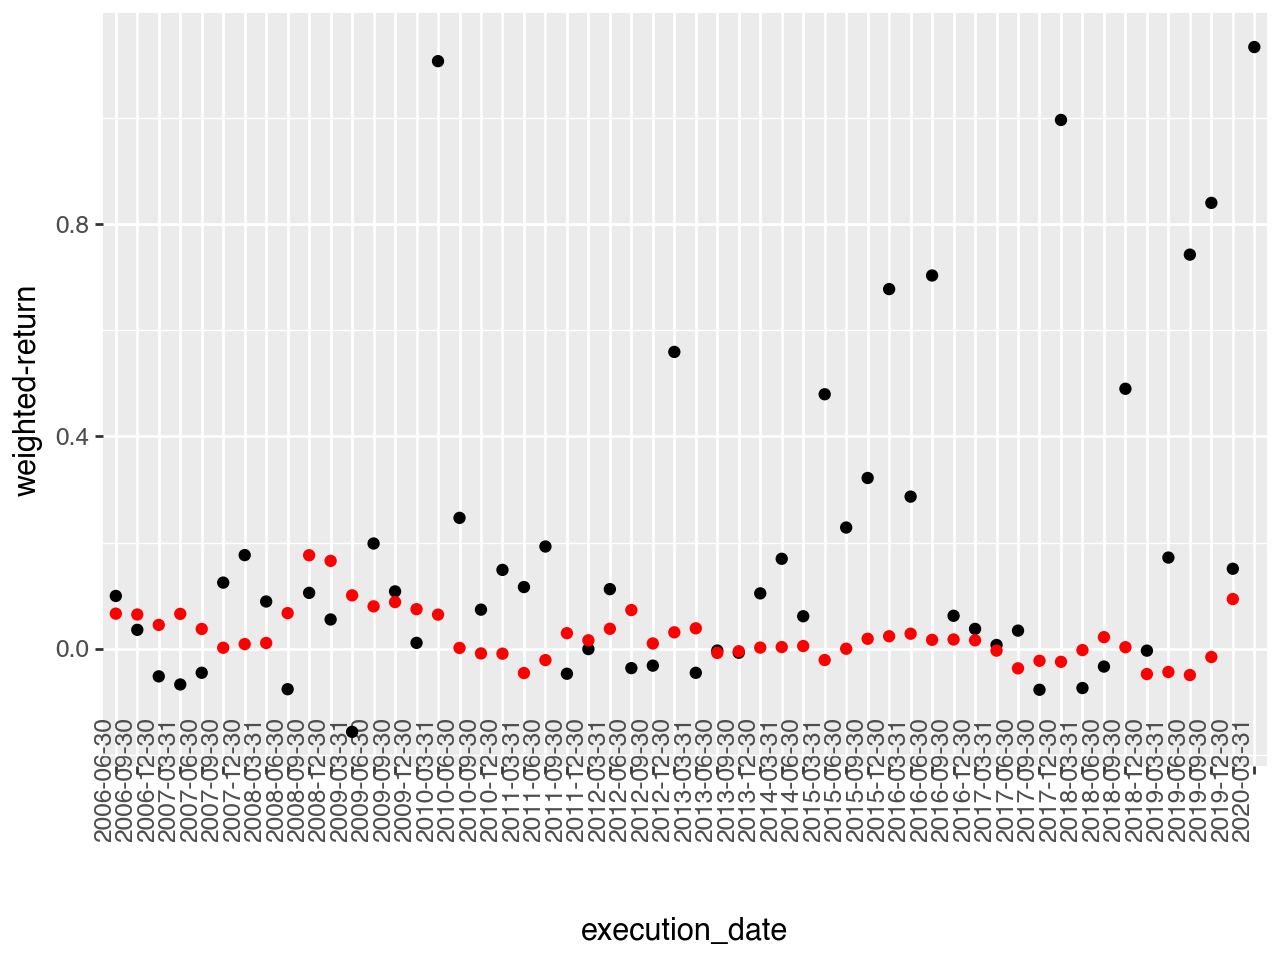

In [26]:
(
    ggplot(
        test_results_final_tree[test_results_final_tree["weighted-return"] < 2],
        aes(x="execution_date"),
    )
    + geom_point(aes(y="weighted-return"))
    + geom_point(aes(y="diff_ch_sp500_baseline"), color="red")
    + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1))
)

Let's see some metrics comparing the built model and the baseline model:
- Periods where we perform better than the baseline model
- Median performance vs baseline model
- Mean performance vs baseline model

In [27]:
better_than_baseline = test_results_final_tree[
    test_results_final_tree["weighted-return"]
    > test_results_final_tree["diff_ch_sp500_baseline"]
]
len(better_than_baseline) / len(test_results_final_tree)

0.6607142857142857

In [28]:
print(test_results_final_tree["weighted-return"].median())
print(test_results_final_tree["diff_ch_sp500_baseline"].median())
print(test_results_final_tree["weighted-return"].mean())
print(test_results_final_tree["diff_ch_sp500_baseline"].mean())

0.10471844503860958
0.01073768184261537
4.029023035251342
0.021320604169533214


## Generalization

We are going to check if the model is generalizing well. We are going to check the performance of the model in the training set and in the test set. If the model is overfitting, the performance in the training set is going to be much better than the performance in the test set.
To do so, we are going to plot the learning curve of the model.

In [29]:
def return_learning_curve(set_):
    learning_curves = pd.DataFrame()
    for date in all_results:
        learning_curve = pd.DataFrame(all_results[(date)][set_])
        learning_curve["n_trees"] = list(range(len(learning_curve)))
        learning_curve["execution_date"] = date
        learning_curves = pd.concat([learning_curves, learning_curve])

    for column in learning_curves.columns:
        if column not in ["n_trees", "execution_date"]:
            first_metric = learning_curves[[column, "execution_date"]].drop_duplicates(
                ["execution_date"]
            )
            first_metric = first_metric.rename(columns={column: "first_" + column})
            learning_curves = pd.merge(
                learning_curves, first_metric, on="execution_date"
            )
            learning_curves["norm_" + column] = (
                learning_curves[column] - learning_curves["first_" + column]
            ) / learning_curves["first_" + column]
            learning_curves = learning_curves.drop(columns="first_" + column)
    learning_curves["execution_date"] = learning_curves["execution_date"].astype(str)

    return learning_curves


In [30]:
test_lc = return_learning_curve("valid_0")
train_lc = return_learning_curve("training")

In [31]:
test_lc["n_trees_cat"] = pd.Categorical(
    test_lc["n_trees"], categories=sorted(test_lc["n_trees"].unique())
)
train_lc["n_trees_cat"] = pd.Categorical(
    train_lc["n_trees"], categories=sorted(train_lc["n_trees"].unique())
)

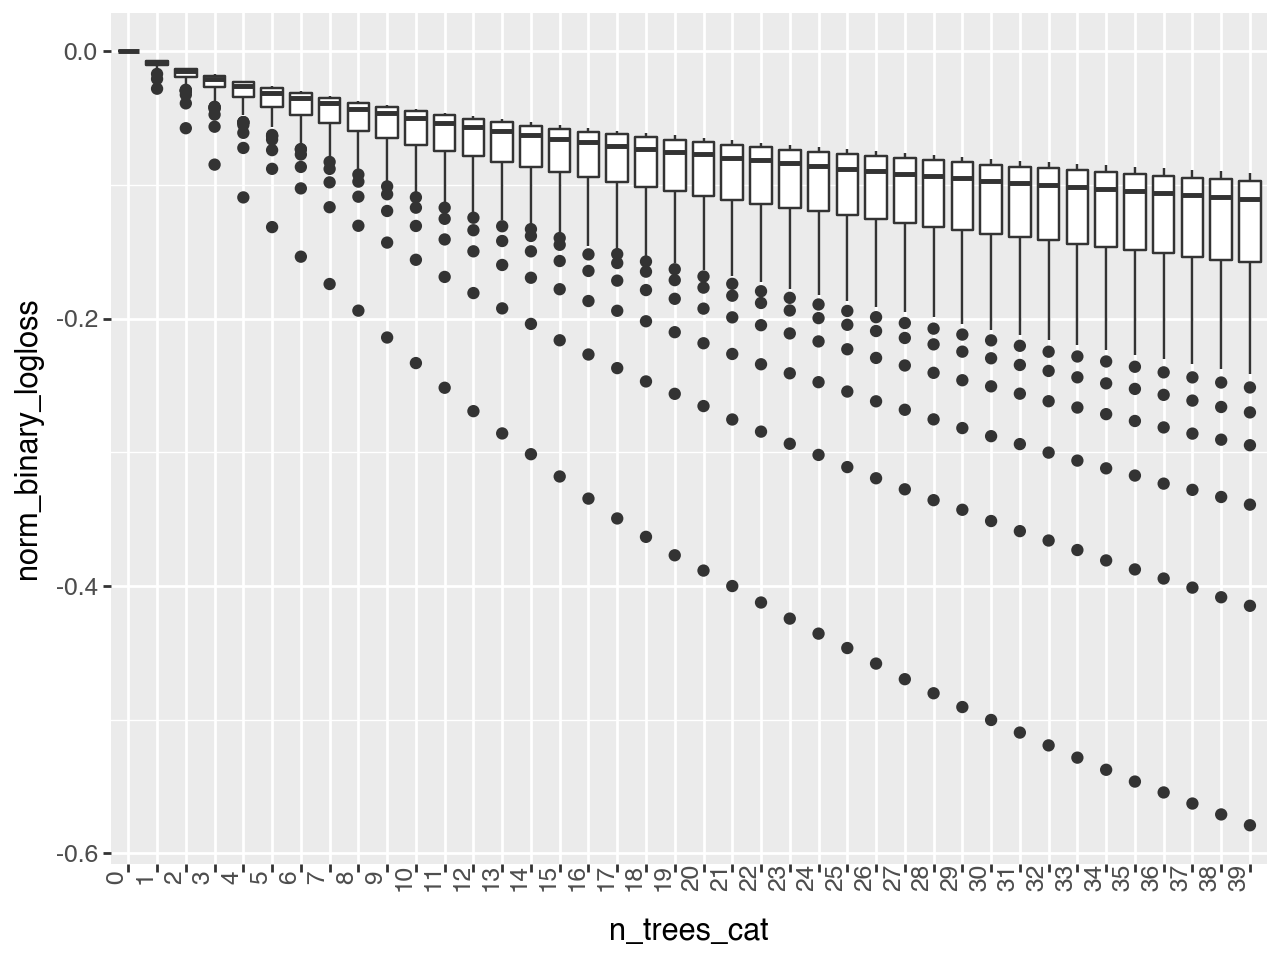

In [32]:
(
    ggplot(train_lc, aes(x="n_trees_cat", y="norm_binary_logloss"))
    + geom_boxplot()
    + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1))
)

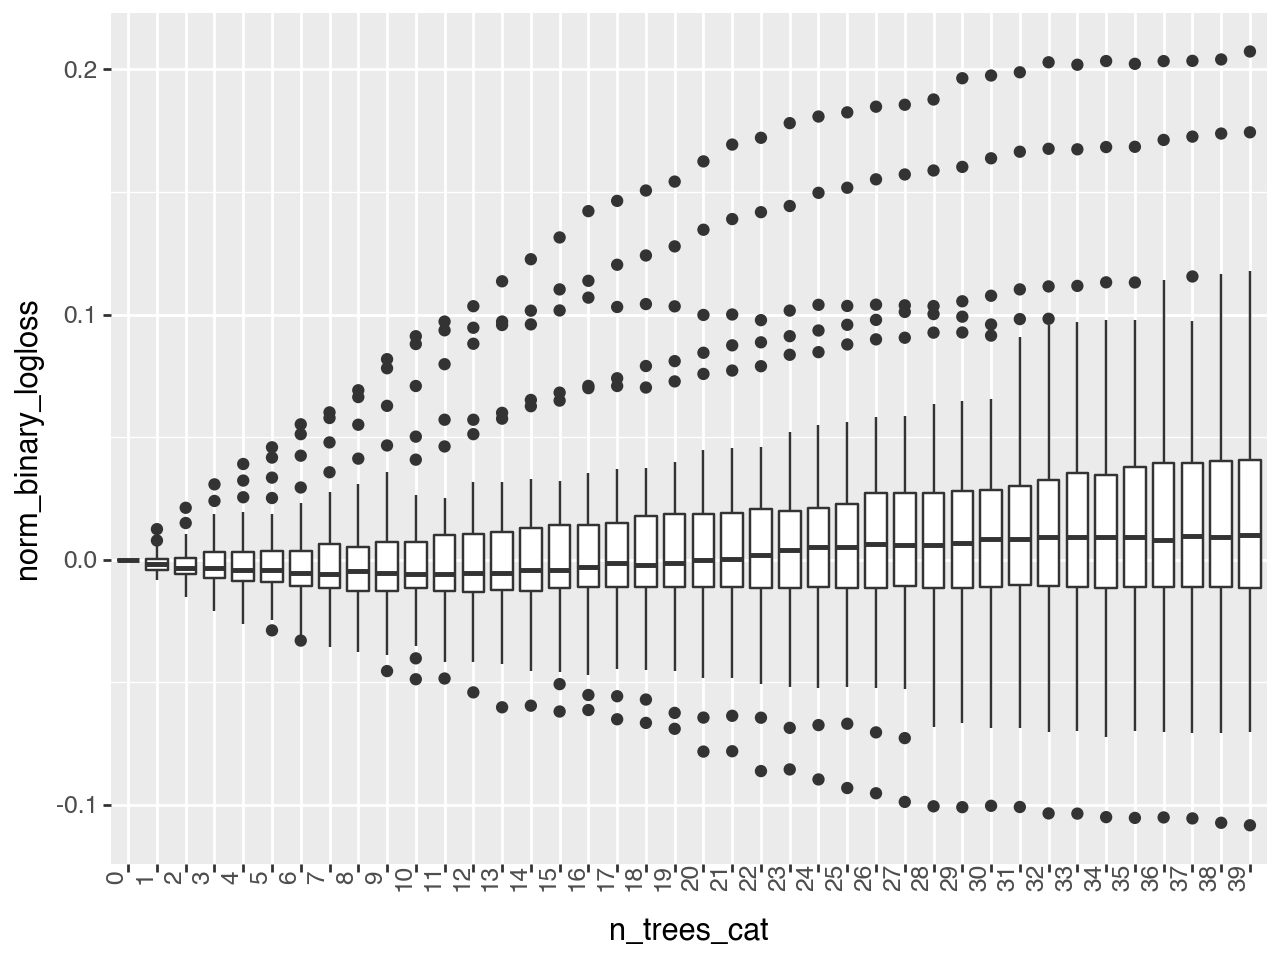

In [33]:
(
    ggplot(test_lc, aes(x="n_trees_cat", y="norm_binary_logloss"))
    + geom_boxplot()
    + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1))
)

The model quickly worsens, this is a problem we have to solve. Let's take a closer look

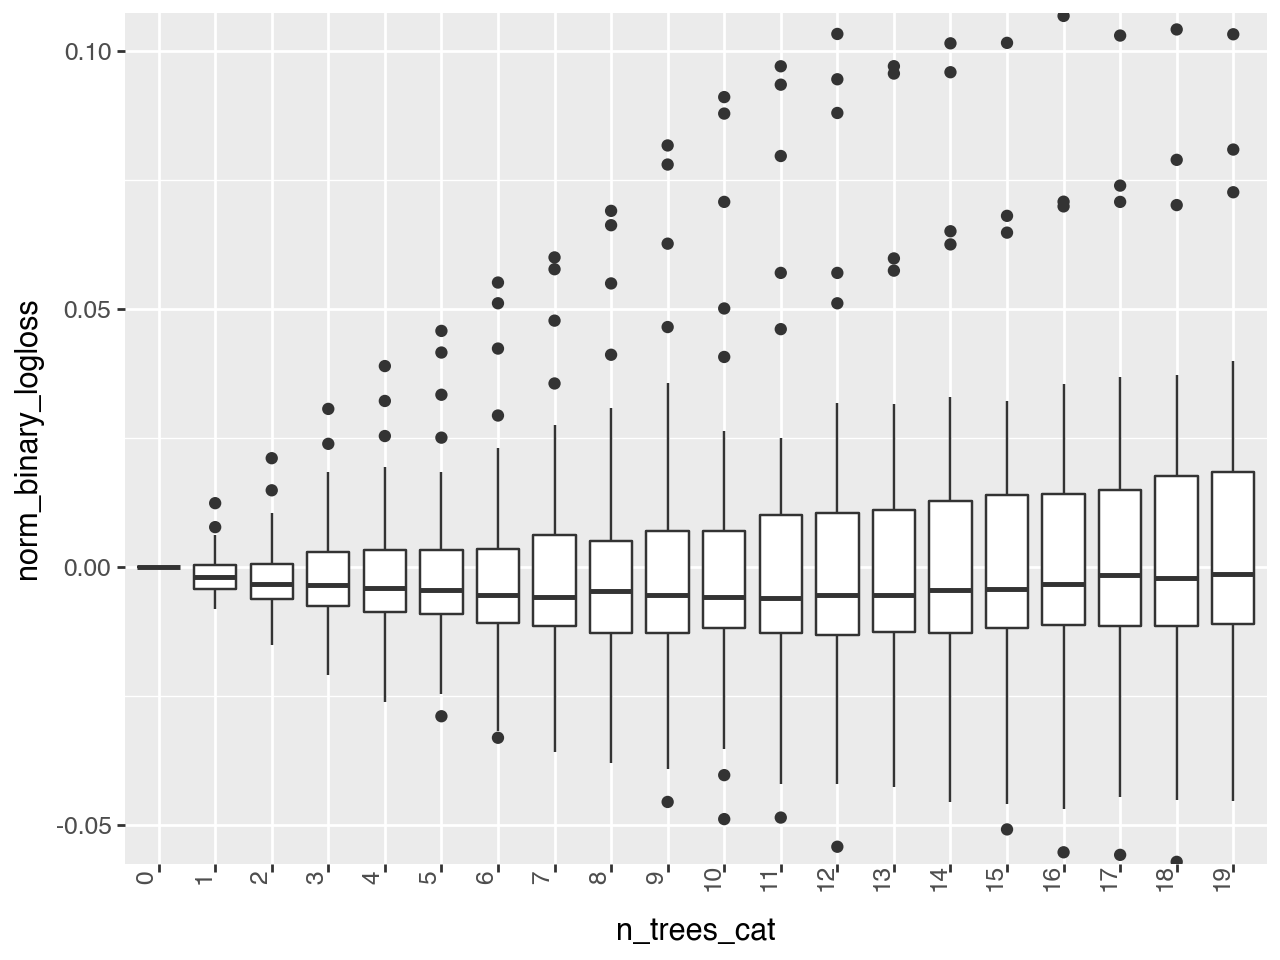

In [34]:
(
    ggplot(
        test_lc[test_lc["n_trees"] < 20], aes(x="n_trees_cat", y="norm_binary_logloss")
    )
    + geom_boxplot()
    + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1))
    + coord_cartesian(ylim=(-0.05, 0.1))
)

We see that the models starts to improve a bit: at least the 50% (median) of the errors are lowering, even though there are a few that quickly increase. Also after the tenth tree, the model starts to worsen. This is a clear sign of overfitting. Let's try to solve this problem by tuning the hyperparameters of the model:
- Learning rate
- N stimators
- path_smooth
- num_leaves

In [35]:
params = {
    "random_state": 42,
    "verbosity": -1,
    "n_jobs": 10,
    "objective": "binary",
    "metric": "binary_logloss",
    "path_smooth": 0.2,
    "n_estimators": 20,
    "learning_rate": 0.001,
}

all_results = {}
all_predicted_tickers_list = []
all_models = {}

In [36]:
for execution_date in execution_dates:
    all_results, all_predicted_tickers_list, all_models, model, X_train, X_test = (
        run_model_for_execution_date(
            execution_date,
            all_results,
            all_predicted_tickers_list,
            all_models,
            n_trees,
            False,
        )
    )
all_predicted_tickers = pd.concat(all_predicted_tickers_list)

In [37]:
def create_and_combine_lc():
    test_lc = return_learning_curve("valid_0")
    train_lc = return_learning_curve("training")
    train_lc["n_trees_cat"] = pd.Categorical(
        train_lc["n_trees"], categories=sorted(train_lc["n_trees"].unique())
    )
    test_lc["n_trees_cat"] = pd.Categorical(
        test_lc["n_trees"], categories=sorted(test_lc["n_trees"].unique())
    )
    train_lc["set"] = "train"
    test_lc["set"] = "test"
    data_lc = pd.concat([train_lc, test_lc])
    return data_lc


data_lc = create_and_combine_lc()


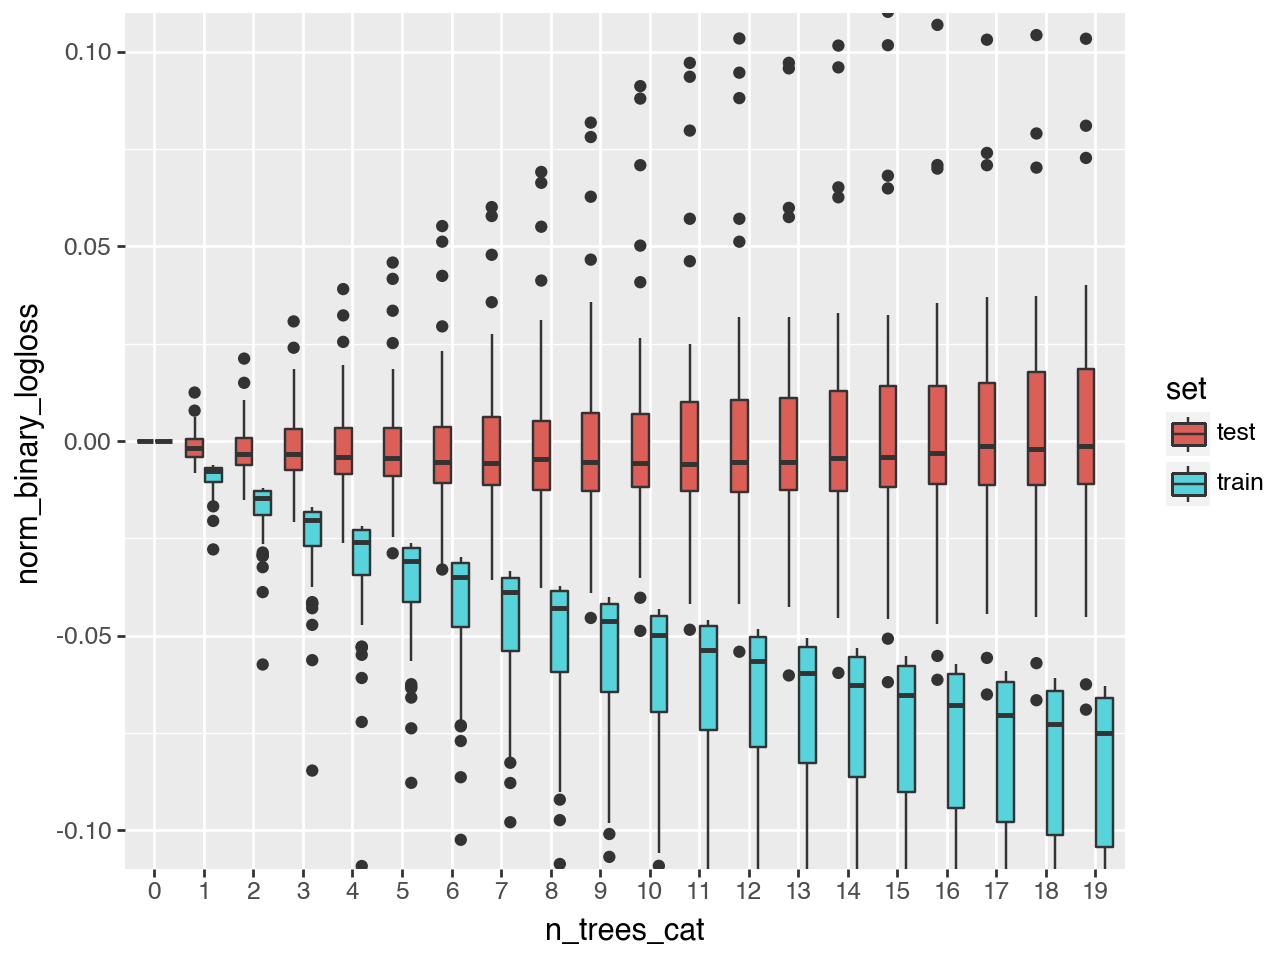

In [38]:
(
    ggplot(
        data_lc[data_lc["n_trees"] < 20],
        aes(x="n_trees_cat", y="norm_binary_logloss", fill="set"),
    )
    + geom_boxplot(outlier_alpha=None)
    + coord_cartesian(ylim=(-0.1, 0.1))
)


## Feature Importance

Let's check if the importance the model gives to each feature is logical or there is some kind of data leakage.

We won't use the feature importance function for trees since it gives more importance to the variables with higher cardinality or higher range in case of numerical features. Instead, we'll use permutation importance since it'll work better

In [39]:
from sklearn.inspection import permutation_importance
import sklearn


def train_model(train_set, test_set, compute_importance=False):
    global params
    to_remove = get_columns_to_remove()

    X_train = train_set.drop(columns=to_remove, errors="ignore")
    X_test = test_set.drop(columns=to_remove, errors="ignore")

    y_train = train_set["target"]
    y_test = test_set["target"]

    model = lgb.LGBMClassifier(**params)
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

    eval_result = {}
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test), (X_train, y_train)],
        eval_metric=top_wt_performance,
        callbacks=[lgb.record_evaluation(eval_result)],
    )
    if compute_importance:
        r = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)
        feature_names = X_test.columns
        df_permutation_importance = pd.DataFrame(
            {"importance": r.importances_mean, "feature": feature_names}
        )

    else:
        df_permutation_importance = pd.DataFrame()
    
    return model, eval_result, X_train, X_test, df_permutation_importance

In [40]:
def run_model_for_execution_date(execution_date, all_results, all_predicted_tickers_list, all_models, include_nulls_in_test=False, compute_importance=False):
    global train_set
    global test_set
    global all_permutation_importances

    # Split the dataset between train and test
    train_set, test_set = split_train_test_by_period(data_set, execution_date, include_nulls_in_test=include_nulls_in_test)
    train_size, _ = train_set.shape
    test_size, _ = test_set.shape
    model = None
    X_train = None
    X_test = None

    # If both train and test are not empty
    if train_size > 0 and test_size > 0:
        model, evals_result, X_train, X_test, df_permutation_importance = train_model(train_set, test_set, compute_importance)
        if type(model) == lgb.sklearn.LGBMClassifier:
            model = model.booster_
        test_set['prob'] = model.predict(X_test)
        test_set = test_set.sort_values('prob', ascending=False)
        predicted_tickers = test_set
        predicted_tickers["execution_date"] = execution_date
        all_results[execution_date] = evals_result
        all_models[execution_date] = model
        all_predicted_tickers_list.append(predicted_tickers)
        df_permutation_importance["execution_date"] = execution_date
        all_permutation_importances = pd.concat([all_permutation_importances, df_permutation_importance])

    return all_results, all_predicted_tickers_list, all_models, model, X_train, X_test


In [41]:
def train_model_across_periods(train_period_frequency=1, compute_importance=False):
    global all_results
    global all_predicted_tickers_list
    global all_models
    global all_predicted_tickers

    for i, execution_date in enumerate(execution_dates):
        if i % train_period_frequency == 0:
            print(execution_date)
            all_results, all_predicted_tickers_list, all_models, model, X_train, X_test = run_model_for_execution_date(
                execution_date, all_results, all_predicted_tickers_list, all_models, 
                include_nulls_in_test=False, compute_importance=compute_importance)
    all_predicted_tickers = pd.concat(all_predicted_tickers_list)


In [42]:
params = {
    "random_state": 1,
    "verbosity": -1,
    "n_jobs": 10,
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 1e-3,
    "path_smooth": 0.2,
    "n_estimators": 20
}

all_results = {}
all_predicted_tickers_list = []
all_models = {}
all_permutation_importances = pd.DataFrame()

train_model_across_periods(train_period_frequency=4, compute_importance=True)

2005-06-30T00:00:00.000000000
2006-06-30T00:00:00.000000000
2007-06-30T00:00:00.000000000
2008-06-30T00:00:00.000000000
2009-06-30T00:00:00.000000000
2010-06-30T00:00:00.000000000
2011-06-30T00:00:00.000000000
2012-06-30T00:00:00.000000000
2013-06-30T00:00:00.000000000
2014-06-30T00:00:00.000000000
2015-06-30T00:00:00.000000000
2016-06-30T00:00:00.000000000
2017-06-30T00:00:00.000000000
2018-06-30T00:00:00.000000000
2019-06-30T00:00:00.000000000
2020-06-30T00:00:00.000000000


In [76]:
all_permutation_importances = all_permutation_importances.sort_values(["execution_date", "importance"], ascending=False)

all_permutation_importances_sum = all_permutation_importances.groupby(["feature"])["importance"].mean().reset_index()
all_permutation_importances_sum = all_permutation_importances_sum.sort_values("importance", ascending=False)
all_permutation_importances_sum = all_permutation_importances_sum.head(10)

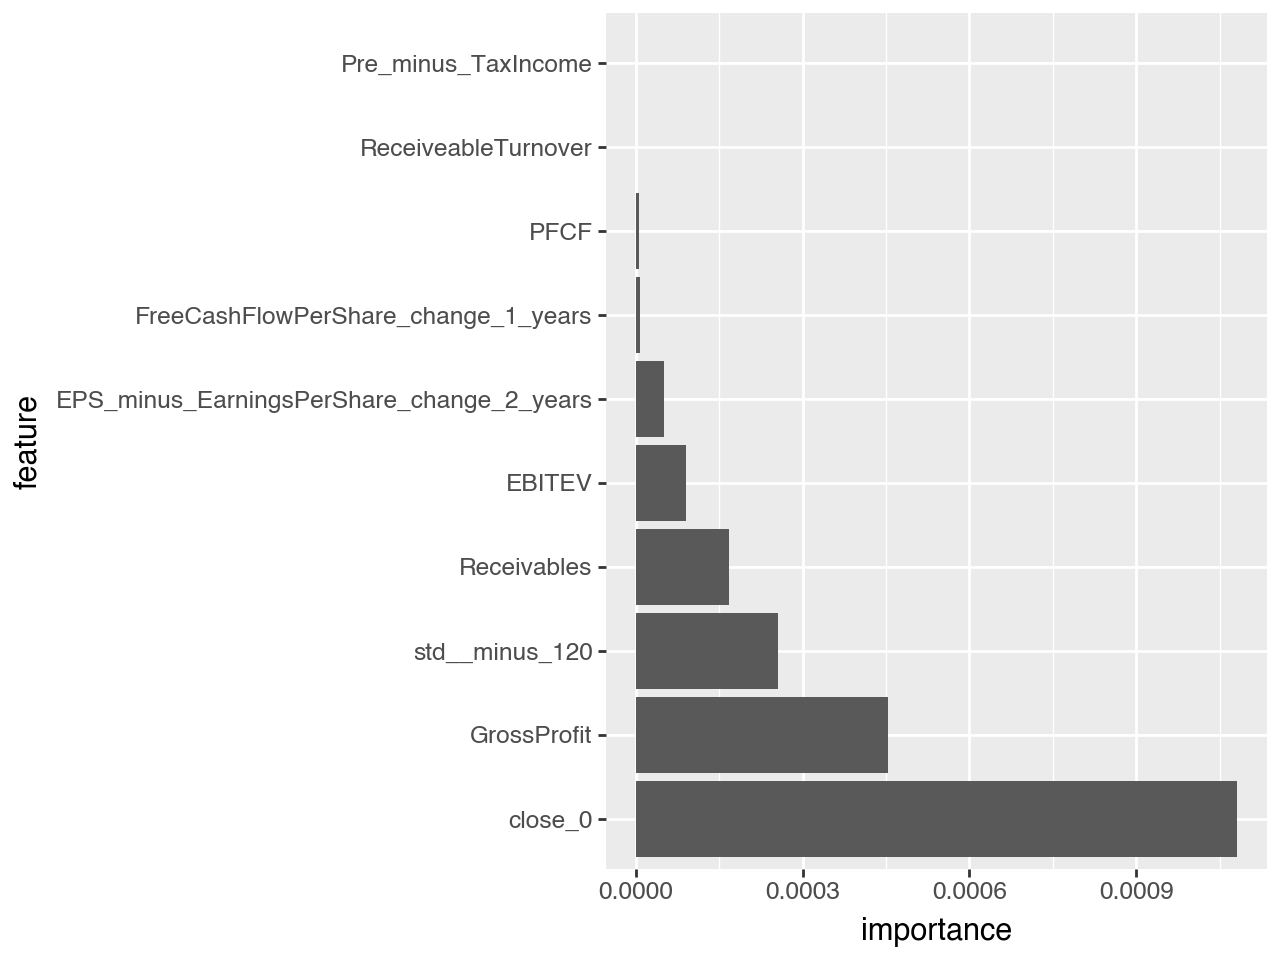

In [77]:
ggplot(all_permutation_importances_sum.head(10)) + \
    geom_col(aes(x="feature", y="importance")) + \
    coord_flip() + \
    scale_x_discrete(limits=all_permutation_importances_sum["feature"])

`close_0` shouldn't be such an important feature as the price of the stock in the purchase moment doesn't really define the performance of the stock in 1 year. If that's true, we should just buy stocks with high (or low, depending on the weight) price and just wait to beat the market, which doesn't really make sense. 

What could be more reasonable is that variables like fundamentals or valuation metrics such as EV/EBITDA have higher importance.

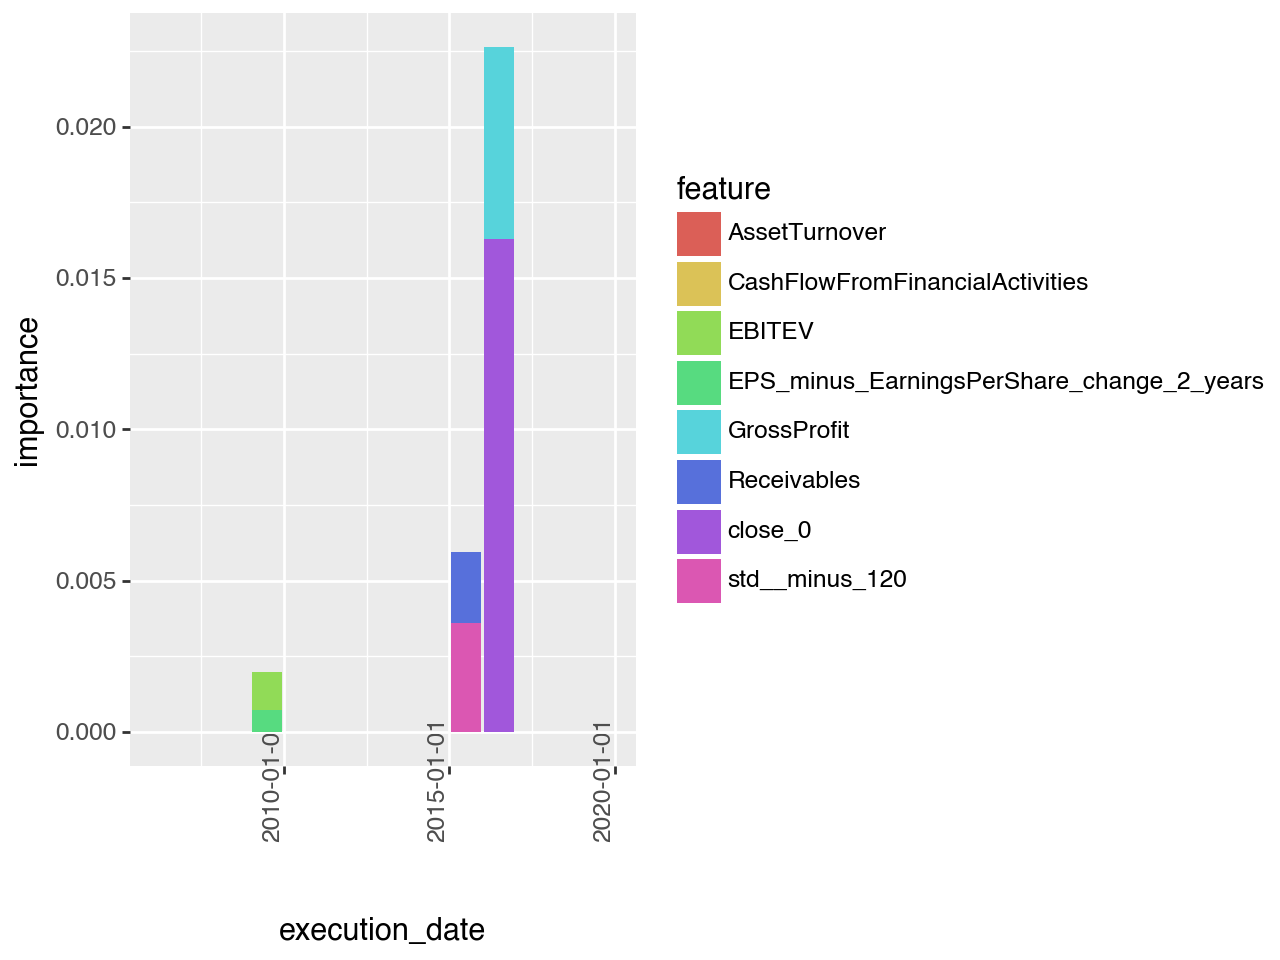

In [78]:
all_permutation_importances["rank"] = all_permutation_importances.groupby("execution_date").cumcount()
r_all_permutation_importances = all_permutation_importances[all_permutation_importances["rank"] <2]
ggplot(r_all_permutation_importances, aes(x="execution_date", y="importance", fill="feature")) +geom_col() +theme(axis_text_x= element_text(angle=90, vjust=0.5, hjust=1))

As we can see: `close_0` isn't even the most important featura in all the periods. So it shouldn't be the most important feature in the model.

Let's see why does it have higher importance in some given periods:

In [91]:
all_permutation_importances[all_permutation_importances["execution_date"] == "2016-06-30"]

,importance,feature,execution_date,rank
87,0.016285,close_0,2016-06-30,0
24,0.006343,GrossProfit,2016-06-30,1
109,0.000091,PFCF,2016-06-30,2
0,0.000000,AssetTurnover,2016-06-30,3
1,0.000000,CashFlowFromFinancialActivities,2016-06-30,4
...,...,...,...,...
133,0.000000,Market_cap__minus_730,2016-06-30,129
50,-0.000524,OperatingIncome,2016-06-30,130
111,-0.000524,PB,2016-06-30,131
93,-0.003872,stock_change__minus_365,2016-06-30,132


Let's look closely to the stocks with higher probability

In [92]:
tickers = all_predicted_tickers[all_predicted_tickers['execution_date'] == "2016-06-30"].sort_values('prob', ascending=False)
tickers[["Ticker", "close_0", "prob"]].head(10)

,Ticker,close_0,prob
107461,BVH,11.044664,0.501029
105932,DB,12.220627,0.501029
106054,CS,10.700000,0.501029
104863,NAV,11.690000,0.501029
105237,ANGI,6.510000,0.501029
106914,EGAN,2.820000,0.501029
106672,TAIT,1.040000,0.501029
106781,TCI,9.959900,0.501029
105723,FUNC,9.765683,0.501029
106916,AEY,1.770000,0.501029


Many of them were meme stocks that blew up, also, we perceive that they are stocks that have suffered and their price has to be changed in order to consider that split.

In [93]:
tickers = all_predicted_tickers[all_predicted_tickers['execution_date'] == "2016-06-30"].sort_values('prob', ascending=True)
tickers[["Ticker", "close_0", "prob"]].head(10)

,Ticker,close_0,prob
106215,ITCI,38.82,0.494218
107607,MCRB,29.05,0.494218
107571,ACAD,32.46,0.494218
105597,TTNP,984.60,0.494218
106404,NVAX,145.40,0.494218
107030,BPTH,398.00,0.494218
107145,ICPT,142.68,0.494218
105645,ARCT,31.43,0.494218
107236,RENN,26.85,0.494218
107215,SNOA,36.09,0.494218


In [106]:
import shap

def get_shap_values_for_ticker_execution_date(execution_date, ticker=None):
    date = np.datetime64(execution_date)
    model_ = all_models[date]
    fn = model_.feature_name()
    X_test = all_predicted_tickers[(all_predicted_tickers["execution_date"] == date)]
    
    if ticker is not None:
        X_test = X_test[X_test["Ticker"] == ticker]
    X_test["Ticker"] = X_test["Ticker"].astype("category")
    X_test = X_test.sort_values("Ticker")
    
    if ticker is not None:
        explainer = shap.Explainer(model_)
        shap_values = explainer(X_test[fn])
        shap_values = shap_values[::1]
    else:
        explainer = shap.Explainer(model_, X_test[fn])
        shap_values = explainer(X_test[fn])
    
    return shap_values


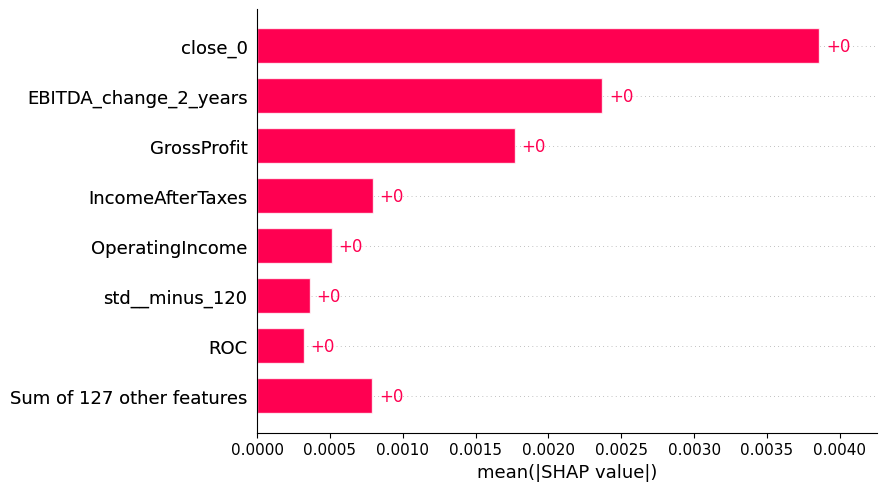

In [107]:
sv = get_shap_values_for_ticker_execution_date('2016-06-30T00:00:00.000000000')
shap.plots.bar(sv, max_display=8)

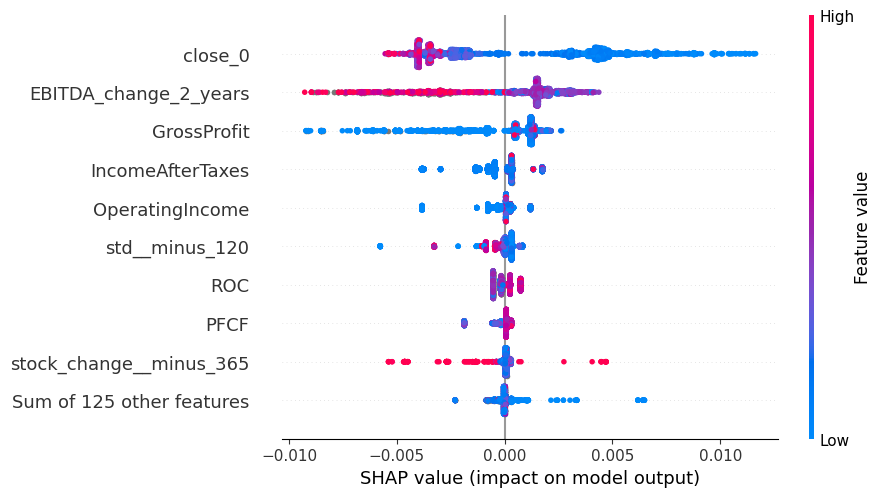

In [108]:
shap.plots.beeswarm(sv)

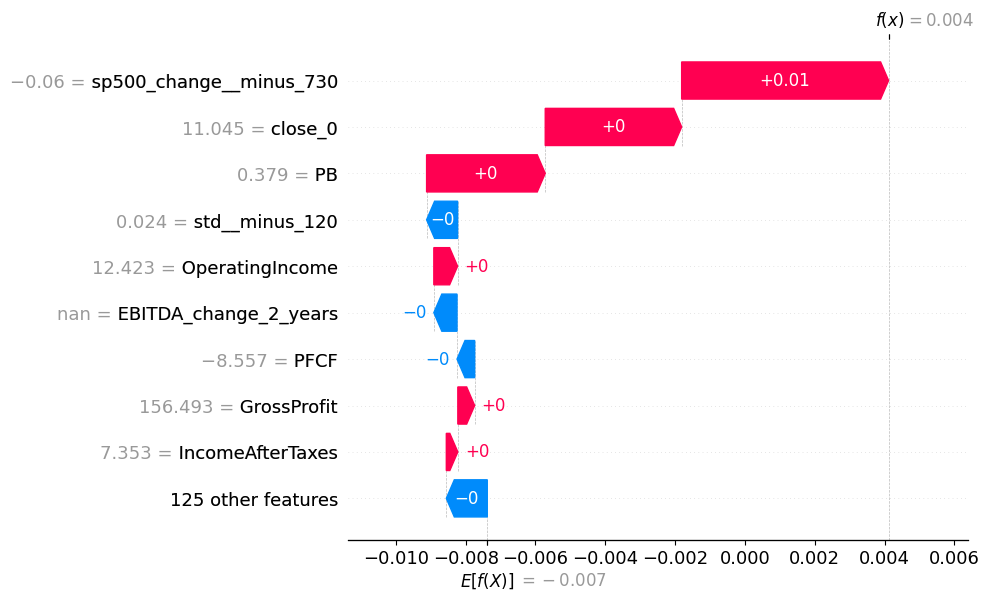

In [111]:
sv = get_shap_values_for_ticker_execution_date('2016-06-30T00:00:00.000000000', ticker='BVH')
shap.plots.waterfall(sv[0])

We see that the blue points in `close_0` are the stocks with lower value in close_0. That means that those stocks with lower value has higher prediction, and the higher value stocks have lower prediction.

One approach to eliminate this data leakage is to remove the features that are related to the price.

In [114]:
def get_columns_to_remove():
    columns_to_remove = [
        "date",
        "improve_sp500",
        "Ticker",
        "freq",
        "set",
        "close_sp500_365",
        "close_365",
        "stock_change_365",
        "sp500_change_365",
        "stock_change_div_365",
        "stock_change_730",
        "sp500_change_365",
        "stock_change_div_730",
        "diff_ch_sp500",
        "diff_ch_avg_500",
        "execution_date", "target", "index", "quarter", "std_730", "count", "stock_change_div__minus_365"
    ]
    columns_to_remove += technical_features
    return columns_to_remove


In [115]:
params = {
    "random_state": 1,
    "verbosity": -1,
    "n_jobs": 10,
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 1e-3,
    "path_smooth": 0.2,
    "n_estimators": 20
}

all_results = {}
all_predicted_tickers_list = []
all_models = {}
all_permutation_importances = pd.DataFrame()

In [116]:
train_model_across_periods(train_period_frequency=1, compute_importance=False)

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

In [117]:
data_lc = create_and_combine_lc()

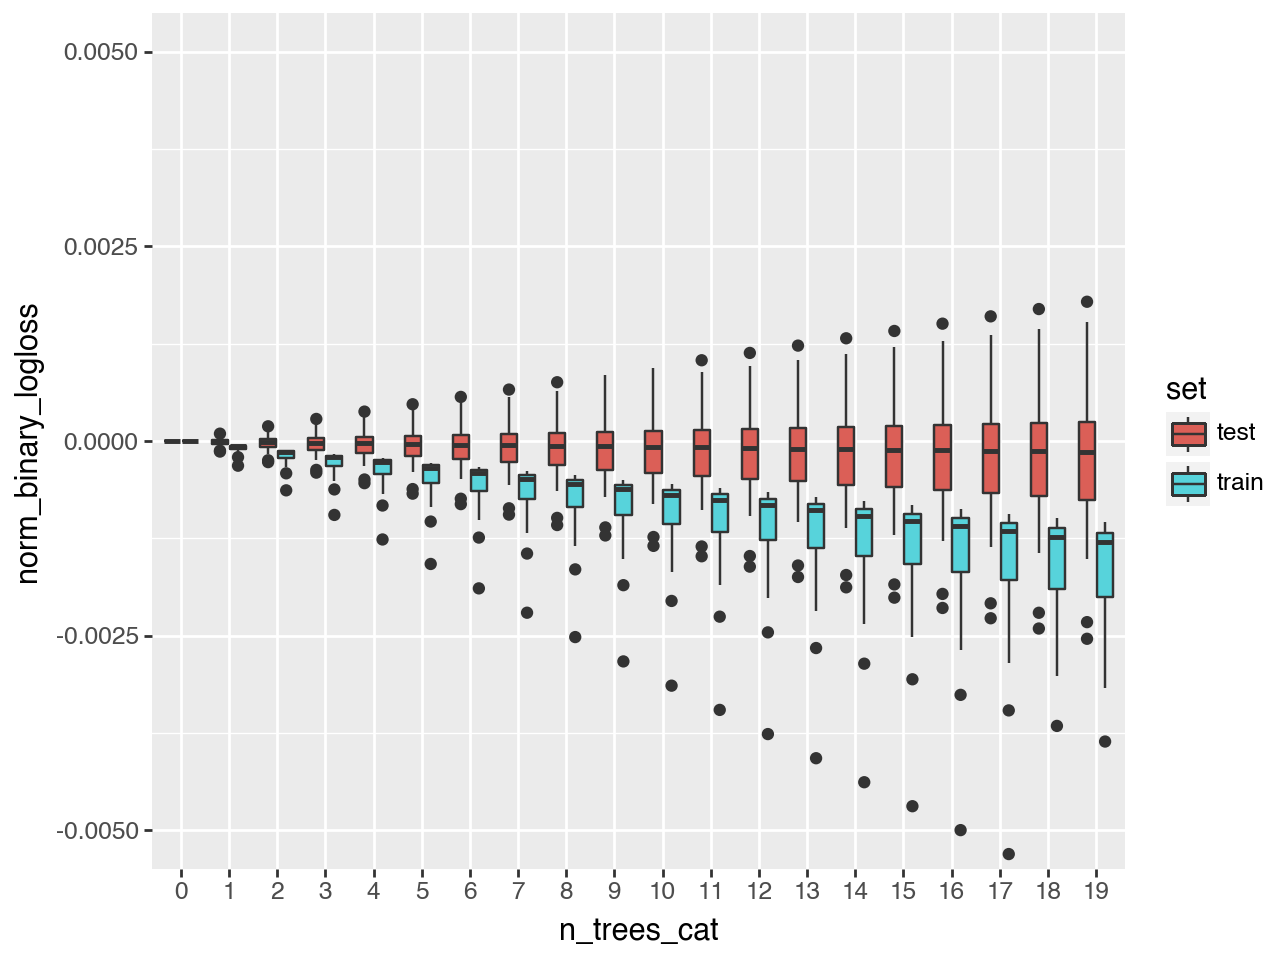

In [122]:
ggplot(data_lc[data_lc["n_trees"] < 20], aes(x="n_trees_cat", y="norm_binary_logloss", fill="set")) + \
    geom_boxplot(outlier_alpha=None) + \
    coord_cartesian(ylim=(-0.005, 0.005))

It's not improving so fast, but at least is getting better. Let's compute the importance

In [123]:
params = {
    "random_state": 1,
    "verbosity": -1,
    "n_jobs": 10,
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 1e-3,
    "path_smooth": 0.2,
    "n_estimators": 20
}

all_results = {}
all_predicted_tickers_list = []
all_models = {}
all_permutation_importances = pd.DataFrame()

train_model_across_periods(train_period_frequency=4, compute_importance=True)

2005-06-30T00:00:00.000000000
2006-06-30T00:00:00.000000000
2007-06-30T00:00:00.000000000
2008-06-30T00:00:00.000000000
2009-06-30T00:00:00.000000000
2010-06-30T00:00:00.000000000
2011-06-30T00:00:00.000000000
2012-06-30T00:00:00.000000000
2013-06-30T00:00:00.000000000
2014-06-30T00:00:00.000000000
2015-06-30T00:00:00.000000000
2016-06-30T00:00:00.000000000
2017-06-30T00:00:00.000000000
2018-06-30T00:00:00.000000000
2019-06-30T00:00:00.000000000
2020-06-30T00:00:00.000000000


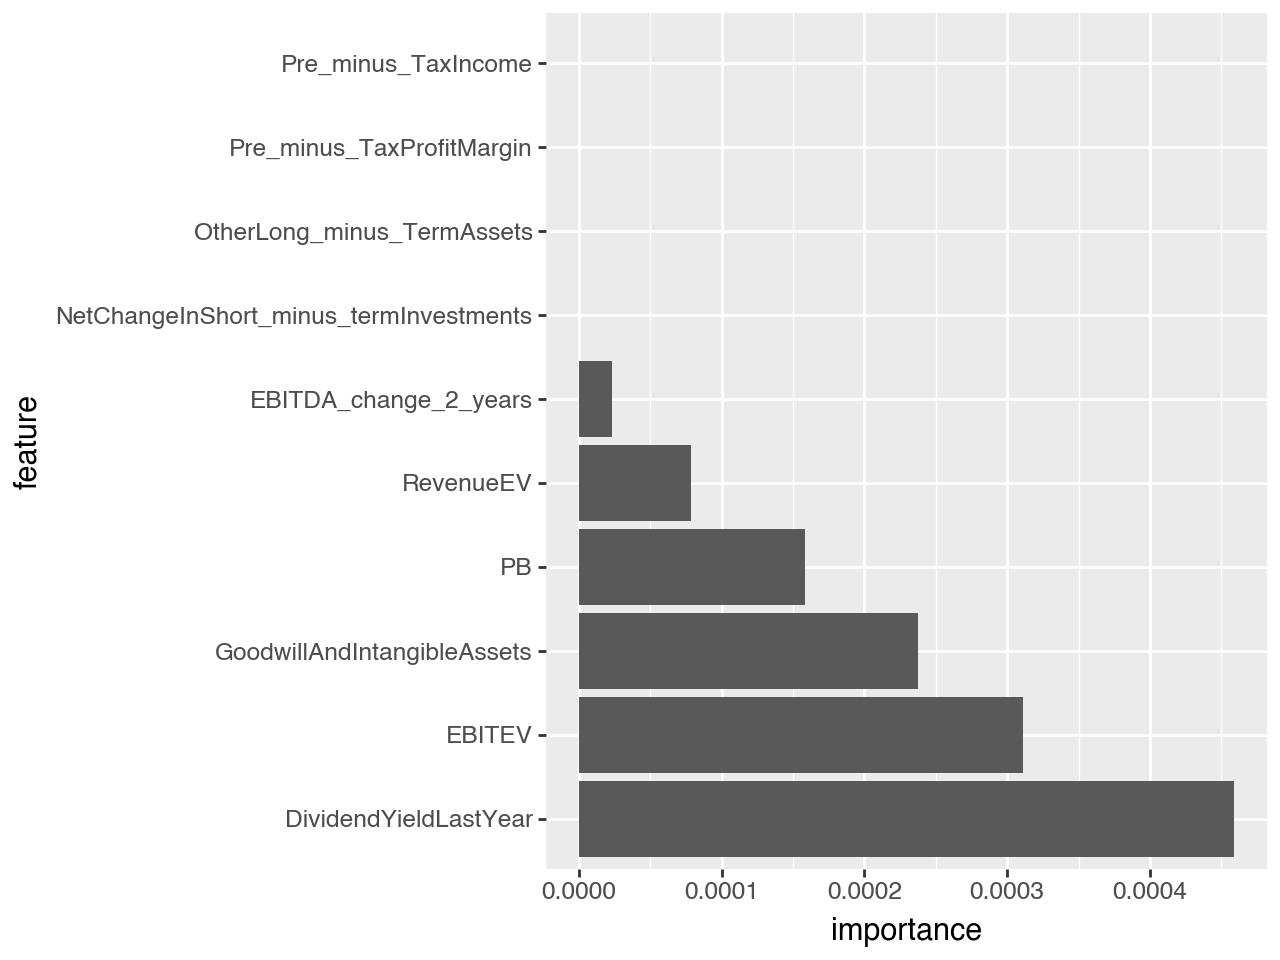

In [124]:
all_permutation_importances = all_permutation_importances.sort_values(["execution_date","importance"],ascending = False)
all_permutation_importances_sum = all_permutation_importances.groupby(["feature"])["importance"].mean().reset_index()
all_permutation_importances_sum = all_permutation_importances_sum.sort_values("importance",ascending = False)
all_permutation_importances_sum = all_permutation_importances_sum.head(10)
ggplot(all_permutation_importances_sum.head(10)) + geom_col(aes(x = "feature", y = "importance")) + coord_flip() + scale_x_discrete(limits = all_permutation_importances_sum["feature"])

Let's redefine the results in terms of weighted return

In [127]:
def train_model_across_periods(train_period_frequency=1, compute_importance=False):
    global all_results
    global all_predicted_tickers_list
    global all_models
    global all_predicted_tickers

    for i, execution_date in enumerate(execution_dates):
        if i % train_period_frequency == 0:
            print(execution_date)
            all_results, all_predicted_tickers_list, all_models, model, X_train, X_test = run_model_for_execution_date(
                execution_date, all_results, all_predicted_tickers_list, all_models, 
                include_nulls_in_test=False, compute_importance=compute_importance)
    all_predicted_tickers = pd.concat(all_predicted_tickers_list)

In [126]:
def train_model(train_set, test_set, compute_importance=True):
    global params
    global model
    to_remove = get_columns_to_remove()

    X_train = train_set.drop(columns=to_remove, errors="ignore")
    X_test = test_set.drop(columns=to_remove, errors="ignore")

    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)
    
    eval_result = {}
    
    model = lgb.train(params, lgb_train, valid_sets=[lgb_test, lgb_train], feval=[top_wt_performance], callbacks=[lgb.record_evaluation(eval_result)])
    return model, eval_result, X_train, X_test, pd.DataFrame()

In [128]:
params = {
    "random_state": 1,
    "verbosity": -1,
    "n_jobs": 10,
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 1e-3,
    "path_smooth": 0.2,
    "n_estimators": 12
}

all_results = {}
all_predicted_tickers_list = []
all_models = {}
all_permutation_importances = pd.DataFrame()

train_model_across_periods(train_period_frequency=1, compute_importance=False)

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

In [129]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

test_results_final_tree = test_results.sort_values(["execution_date", "n_trees"]).drop_duplicates("execution_date", keep="last")
train_results_final_tree = train_results.sort_values(["execution_date", "n_trees"]).drop_duplicates("execution_date", keep="last")

test_results_final_tree = merge_against_benchmark(test_results_final_tree, all_predicted_tickers)

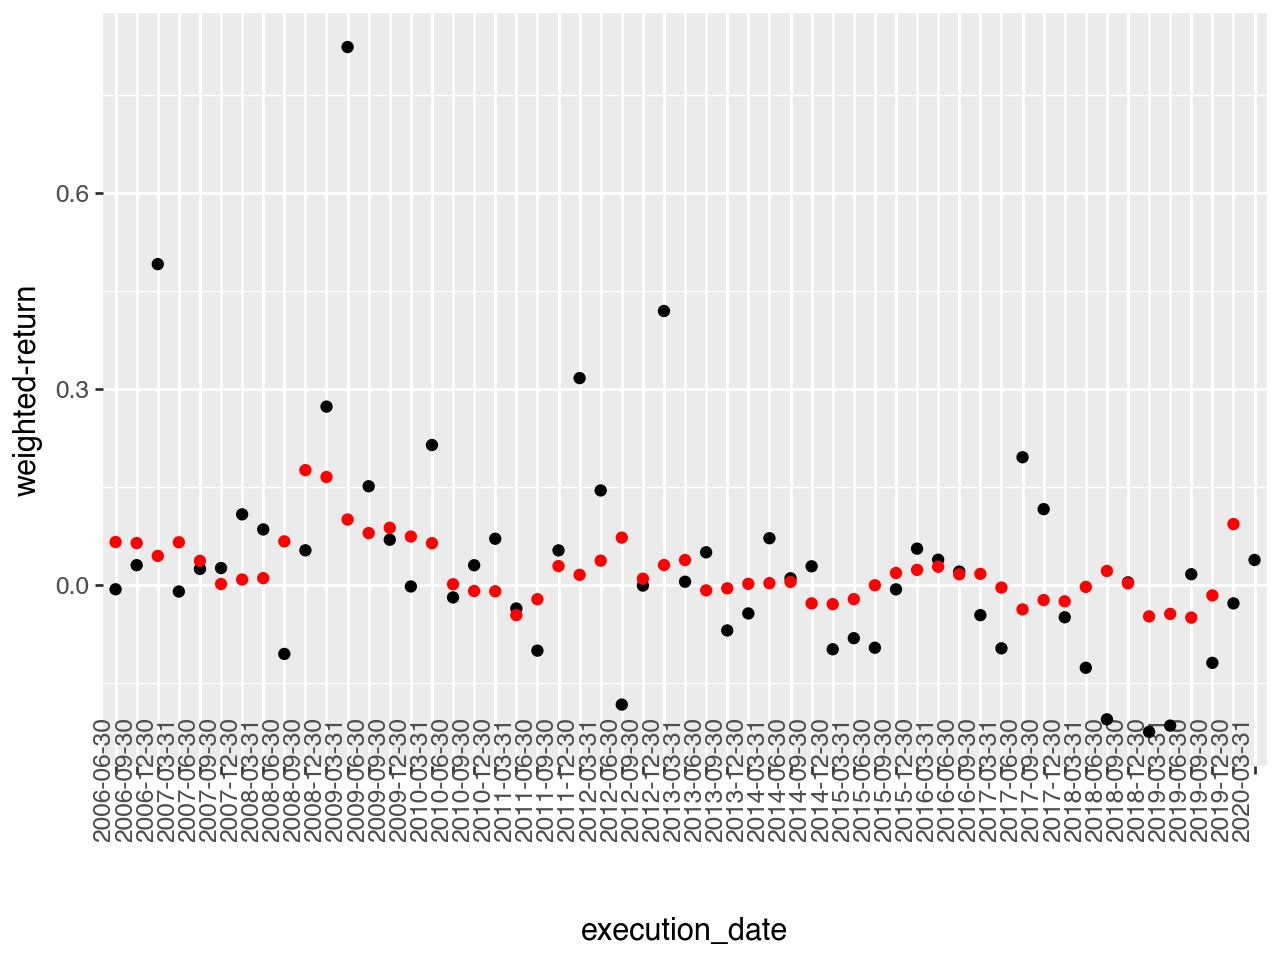

In [130]:
ggplot(test_results_final_tree[test_results_final_tree["weighted-return"] < 2], aes(x="execution_date")) + geom_point(aes(y="weighted-return")) + geom_point(aes(y="diff_ch_sp500_baseline"), color="red") + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1))

This is way more reasonable.

In [131]:
better_than_baseline = test_results_final_tree[test_results_final_tree["weighted-return"] > test_results_final_tree["diff_ch_sp500_baseline"]]
len(better_than_baseline) / len(test_results_final_tree)

0.48214285714285715

In [133]:
test_results_final_tree["weighted-return"].median()

0.018776550580488875

In [135]:
test_results_final_tree["diff_ch_sp500_baseline"].median()

0.01073768184261537

In [134]:
test_results_final_tree["weighted-return"].mean()

0.08116053797610905

In [137]:
test_results_final_tree["diff_ch_sp500_baseline"].mean()

0.021320604169533214